In [2]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt

## 1. Préparation des données et des fonctions de plot

In [3]:
df_data = pd.read_csv('../data/train.csv')
df_data.head(1)

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.0,0.00293,0.00293,0.035156,0.0,0.0,0.004883,0.0,0.025391


In [4]:
df_data.shape

(990, 194)

In [5]:
X = df_data.copy().drop(['id', 'species'],axis='columns').values

species = df_data['species'].unique()

# Création des vecteurs one-hot pour la matrice de targets
t = np.zeros(df_data.shape[0])
for i in range(species.size):
    t[df_data['species'] == species[i]] = i

In [6]:
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3, random_state=0)

In [213]:
#création des listes des valeurs d'hyper-paramètres possibles
all_values_C_linear_poly = np.arange(1,11,1) ####################### revoir les valeurs à prendre ###################
all_values_C_rbf_sigmoid = np.arange(3,11,1)#np.logspace(,1,20) #3 à 7 
all_values_Gamma = np.logspace(-9, 0, 10)
all_values_Degree = [2,3,4,5,6,7,8,9,10]

In [8]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2), len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2), len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.semilogx(grid_param_1, scores_mean[idx, :], '-o', label=name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=10, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=10)
    ax.set_ylabel('CV Average Score', fontsize=10)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)
    ax.grid('on')

In [9]:
def plot_grid_search_single_param(cv_results, grid_param, name_param, figsize=(10, 6)):
    # Get Test Scores Mean for each grid search
    scores_mean = cv_results['mean_test_score']

    # Plot the 2D curve
    plt.figure(figsize=figsize)
    plt.plot(grid_param, scores_mean, '-o')

    # Add labels and a title
    plt.xlabel(name_param)
    plt.ylabel('CV Average Score')
    plt.title("Grid Search Scores", fontsize=12, fontweight='bold')
    
    plt.grid(True)
    plt.show()

## 2. SVM linéaire
### 2.1 sans optimisation

In [145]:
classifieur_linear = svm.SVC(kernel='linear') # noyau lineaire
classifieur_linear.fit(X_train, t_train)

SVC(kernel='linear')

In [162]:
print("Score X_train, t_train : {:.2f}%".format(classifieur_linear.score(X_train, t_train)*100))
print("Score X_test, t_test : {:.2f}%".format(classifieur_linear.score(X_test, t_test)*100))

Score X_train, t_train : 14.29%
Score X_test, t_test : 2.36%


### 2.2 optimisation des hyper-paramètres

In [147]:
# Paramètre à tester
param_grid_svm_linear= {
    'C' : all_values_C_linear_poly
}

# Création du modèle de recherche sur grille
grid_search_svm_linear = GridSearchCV(svm.SVC(kernel='linear'), param_grid_svm_linear, cv=5, verbose=3, n_jobs=-1)

# Entraînement du modèle avec la recherche sur grille
grid_search_svm_linear.fit(X_train, t_train)
print('Done')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\adcol\anaconda3\envs\ta_env\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Done


In [148]:
results_grid_svm_linear = pd.DataFrame.from_dict(grid_search_svm_linear.cv_results_)
print(results_grid_svm_linear)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       0.158575      0.029573         0.036503        0.004068       1   
1       0.162755      0.027197         0.040490        0.007843       2   
2       0.193069      0.019819         0.046476        0.006693       3   
3       0.162365      0.014180         0.047873        0.010556       4   
4       0.178324      0.042107         0.057844        0.021604       5   
5       0.194480      0.038573         0.047871        0.010852       6   
6       0.190692      0.024755         0.050264        0.012012       7   
7       0.196476      0.062111         0.050662        0.023279       8   
8       0.204453      0.037967         0.040491        0.005802       9   
9       0.158176      0.021955         0.025732        0.010694      10   

      params  split0_test_score  split1_test_score  split2_test_score  \
0   {'C': 1}           0.100719           0.122302           0.100719   
1   {'C': 2}           0.179

In [163]:
# Meilleurs paramètres et meilleure précision
print("Meilleur paramètre:", grid_search_svm_linear.best_params_)
print("Meilleure précision sur un split : {:.2f}%".format(grid_search_svm_linear.best_score_*100))
print("Score X_train, t_train : {:.2f}%".format(grid_search_svm_linear.score(X_train, t_train)*100))
print("Score X_test, t_test : {:.2f}%".format(grid_search_svm_linear.score(X_test, t_test)*100))

Meilleur paramètre: {'C': 10}
Meilleure précision sur un split : 74.89%
Score X_train, t_train : 91.92%
Score X_test, t_test : 74.07%


### 2.3 Visualisation de l'évolution de notre score selon l'évolution de nos hyper-paramètres

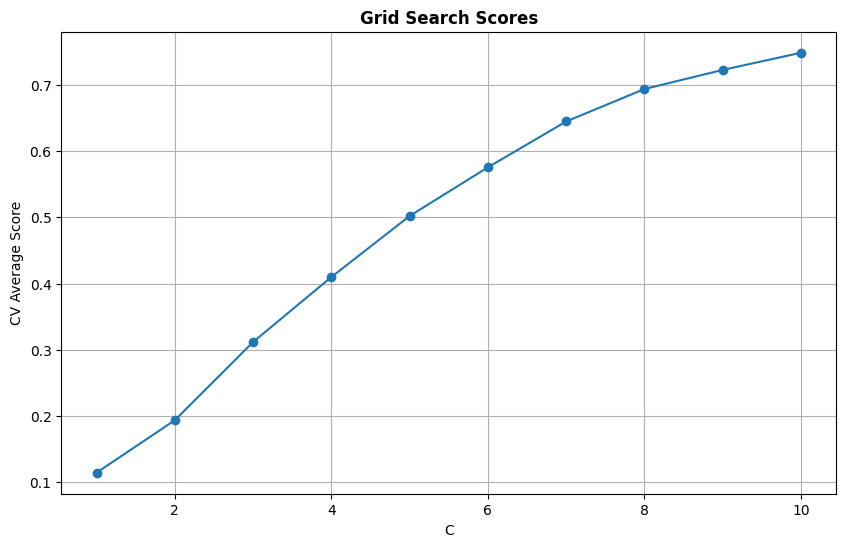

In [164]:
plot_grid_search_single_param(results_grid_svm_linear, all_values_C_linear_poly, 'C')

## 3. SVM noyau rbf
### 3.1 Sans optimisation

In [165]:
classifieur_rbf = svm.SVC(kernel='rbf',gamma=0.7) # noyau rbf 0.7 choisit de manière aléatoire
classifieur_rbf.fit(X_train, t_train)

SVC(gamma=0.7)

In [168]:
print("Score X_train, t_train : {:.2f}%".format(classifieur_rbf.score(X_train, t_train)*100))
print("Score X_test, t_test : {:.2f}%".format(classifieur_rbf.score(X_test, t_test)*100))

Score X_train, t_train : 18.61%
Score X_test, t_test : 4.38%


### 3.2 optimisation des hyper-paramètres

In [105]:
# Paramètre à tester
param_grid_svm_rbf= {
    'C' : all_values_C_rbf_sigmoid,
    'gamma' : all_values_Gamma
}

# Création du modèle de recherche sur grille
grid_search_svm_rbf = GridSearchCV(svm.SVC(kernel='rbf'), param_grid_svm_rbf, cv=5, verbose=3, n_jobs=-1)

# Entraînement du modèle avec la recherche sur grille
grid_search_svm_rbf.fit(X_train, t_train)
print('Done')

Fitting 5 folds for each of 80 candidates, totalling 400 fits


C:\Users\adcol\anaconda3\envs\ta_env\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Done


In [106]:
results_grid_svm_rbf = pd.DataFrame.from_dict(grid_search_svm_rbf.cv_results_)
print(results_grid_svm_rbf)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        0.182113      0.020620         0.082380        0.008592       3   
1        0.146409      0.016259         0.056250        0.006693       3   
2        0.204452      0.041722         0.081780        0.016557       3   
3        0.203854      0.076234         0.057646        0.006320       3   
4        0.216825      0.038049         0.067007        0.019434       3   
..            ...           ...              ...             ...     ...   
75       0.191488      0.033394         0.062035        0.007368      10   
76       0.179719      0.027670         0.060440        0.009947      10   
77       0.180717      0.025399         0.060838        0.009852      10   
78       0.189494      0.028434         0.053058        0.003239      10   
79       0.175131      0.021405         0.054256        0.002999      10   

   param_gamma                      params  split0_test_score  \
0          0.0    {'C'

In [170]:
# Meilleurs paramètres et meilleure précision
print("Meilleur paramètre:", grid_search_svm_rbf.best_params_)
print("Meilleure précision sur un split : {:.2f}%".format(grid_search_svm_rbf.best_score_*100))
print("Score X_train, t_train : {:.2f}%".format(grid_search_svm_rbf.score(X_train, t_train)*100))
print("Score X_test, t_test : {:.2f}%".format(grid_search_svm_rbf.score(X_test, t_test)*100))

Meilleur paramètre: {'C': 10, 'gamma': 1.0}
Meilleure précision sur un split : 87.16%
Score X_train, t_train : 97.98%
Score X_test, t_test : 86.20%


### 3.3 Visualisation de l'évolution de notre score selon l'évolution de nos hyper-paramètres

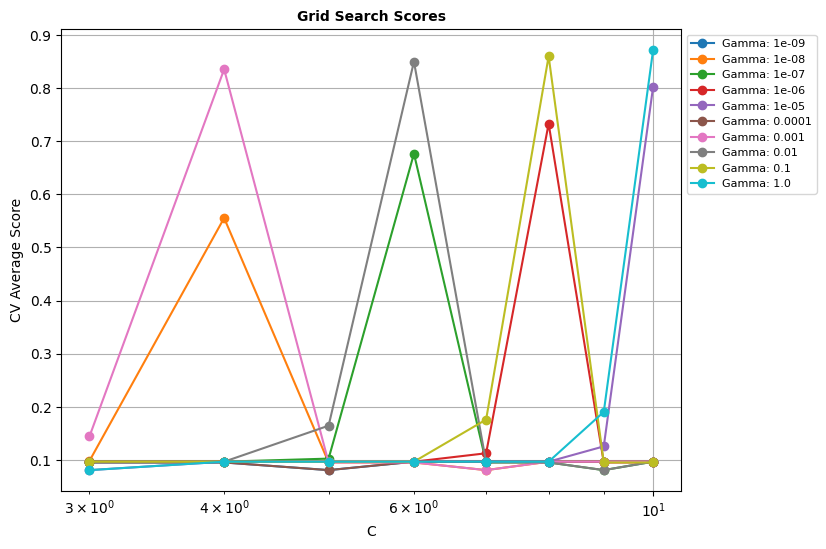

In [109]:
plot_grid_search(results_grid_svm_rbf, all_values_C_rbf_sigmoid, all_values_Gamma, 'C', 'Gamma')

## 4. SVM Noyau Polynomial
### 4.1 sans optimisation

In [261]:
classifieur_poly = svm.SVC(kernel='poly', degree=2, gamma="auto") # noyau rbf 0.7 choisit de manière aléatoire
classifieur_poly.fit(X_train, t_train)

SVC(degree=2, gamma='auto', kernel='poly')

In [262]:
print("Score X_train, t_train : {:.2f}%".format(classifieur_poly.score(X_train, t_train)*100))
print("Score X_test, t_test : {:.2f}%".format(classifieur_poly.score(X_test, t_test)*100))

Score X_train, t_train : 7.50%
Score X_test, t_test : 0.00%


### 4.2 optimisation des hyper-paramètres

In [285]:
# Paramètre à tester
param_grid_svm_poly= {
    'C' : all_values_C_linear_poly,
    'degree' : all_values_Degree
}

# Création du modèle de recherche sur grille
grid_search_svm_poly = GridSearchCV(svm.SVC(kernel="poly", gamma='auto'), param_grid_svm_poly, cv=5, verbose=3, n_jobs=-1)

# Entraînement du modèle avec la recherche sur grille
grid_search_svm_poly.fit(X_train, t_train)
print('Done')

Fitting 5 folds for each of 90 candidates, totalling 450 fits


C:\Users\adcol\anaconda3\envs\ta_env\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Done


In [286]:
results_grid_svm_poly = pd.DataFrame.from_dict(grid_search_svm_poly.cv_results_)
print(results_grid_svm_poly)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        0.146010      0.017881         0.044681        0.012811       1   
1        0.153590      0.025104         0.040891        0.004370       1   
2        0.162366      0.039710         0.031715        0.002035       1   
3        0.149200      0.007559         0.042087        0.011059       1   
4        0.155383      0.019168         0.044481        0.011382       1   
..            ...           ...              ...             ...     ...   
85       0.196873      0.028072         0.047672        0.016977      10   
86       0.171940      0.018939         0.044281        0.015601      10   
87       0.199868      0.018500         0.050660        0.014705      10   
88       0.191688      0.029928         0.037300        0.010881      10   
89       0.157178      0.025148         0.029921        0.002600      10   

   param_degree                   params  split0_test_score  \
0             2    {'C':

In [287]:
# Meilleurs paramètres et meilleure précision
print("Meilleur paramètre:", grid_search_svm_poly.best_params_)
print("Meilleure précision sur un split : {:.2f}%".format(grid_search_svm_poly.best_score_*100))
print("Score X_train, t_train : {:.2f}%".format(grid_search_svm_poly.score(X_train, t_train)*100))
print("Score X_test, t_test : {:.2f}%".format(grid_search_svm_poly.score(X_test, t_test)*100))

Meilleur paramètre: {'C': 1, 'degree': 2}
Meilleure précision sur un split : 8.66%
Score X_train, t_train : 7.50%
Score X_test, t_test : 0.00%


### Gamma optimisation et pas auto

In [270]:
# Paramètre à tester
param_grid_svm_poly= {
    'C' : all_values_C_linear_poly,
    'degree' : all_values_Degree,
    'gamma' : all_values_Gamma
}

# Création du modèle de recherche sur grille
grid_search_svm_poly = GridSearchCV(svm.SVC(kernel="poly"), param_grid_svm_poly, cv=5, verbose=3, n_jobs=-1)

# Entraînement du modèle avec la recherche sur grille
grid_search_svm_poly.fit(X_train, t_train)
print('Done')

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


C:\Users\adcol\anaconda3\envs\ta_env\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Done


In [271]:
results_grid_svm_poly = pd.DataFrame.from_dict(grid_search_svm_poly.cv_results_)
# Meilleurs paramètres et meilleure précision
print("Meilleur paramètre:", grid_search_svm_poly.best_params_)
print("Meilleure précision sur un split : {:.2f}%".format(grid_search_svm_poly.best_score_*100))
print("Score X_train, t_train : {:.2f}%".format(grid_search_svm_poly.score(X_train, t_train)*100))
print("Score X_test, t_test : {:.2f}%".format(grid_search_svm_poly.score(X_test, t_test)*100))

Meilleur paramètre: {'C': 10, 'degree': 2, 'gamma': 1.0}
Meilleure précision sur un split : 17.89%
Score X_train, t_train : 21.93%
Score X_test, t_test : 9.09%


### 4.3 Visualisation de l'évolution de notre score selon l'évolution de nos hyper-paramètres

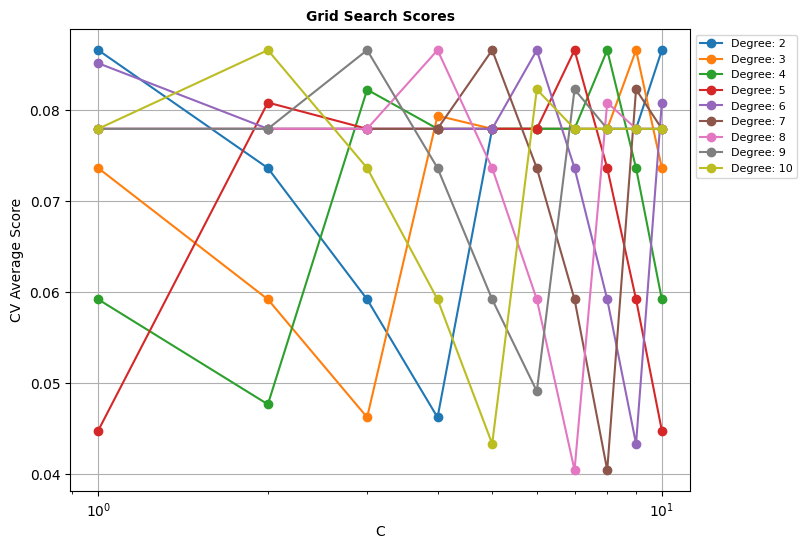

In [288]:
plot_grid_search(results_grid_svm_poly, all_values_C_linear_poly, all_values_Degree, 'C', 'Degree')

## 5. SVM Noyau Simoidal
### 5.1 sans optimisation

In [291]:
classifieur_sigmoid = svm.SVC(kernel='sigmoid', gamma=0.7) # noyau rbf 0.7 choisit de manière aléatoire
classifieur_sigmoid.fit(X_train, t_train)

SVC(gamma=0.7, kernel='sigmoid')

In [292]:
print("Score X_train, t_train : {:.2f}%".format(classifieur_sigmoid.score(X_train, t_train)*100))
print("Score X_test, t_test : {:.2f}%".format(classifieur_sigmoid.score(X_test, t_test)*100))

Score X_train, t_train : 10.10%
Score X_test, t_test : 0.67%


### 5.2 optimisation des hyper-paramètres

In [293]:
# Paramètre à tester
param_grid_svm_sigmoid= {
    'C' : all_values_C_rbf_sigmoid,
    'gamma' : all_values_Gamma
}

# Création du modèle de recherche sur grille
grid_search_svm_sigmoid = GridSearchCV(svm.SVC(kernel="sigmoid"), param_grid_svm_sigmoid, cv=5, verbose=3, n_jobs=-1)

# Entraînement du modèle avec la recherche sur grille
grid_search_svm_sigmoid.fit(X_train, t_train)
print('Done')

Fitting 5 folds for each of 80 candidates, totalling 400 fits


C:\Users\adcol\anaconda3\envs\ta_env\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Done


In [294]:
results_grid_svm_sigmoid = pd.DataFrame.from_dict(grid_search_svm_sigmoid.cv_results_)
print(results_grid_svm_sigmoid)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        0.142020      0.004166         0.043884        0.008345       3   
1        0.143617      0.008053         0.057646        0.024722       3   
2        0.151394      0.015339         0.041091        0.008996       3   
3        0.177525      0.022978         0.035904        0.004039       3   
4        0.176928      0.015914         0.038896        0.001411       3   
..            ...           ...              ...             ...     ...   
75       0.192684      0.030794         0.044681        0.015391      10   
76       0.190490      0.027733         0.045479        0.017589      10   
77       0.145597      0.008411         0.037699        0.014636      10   
78       0.184307      0.025957         0.054656        0.018305      10   
79       0.185304      0.013811         0.039495        0.004213      10   

   param_gamma                      params  split0_test_score  \
0          0.0    {'C'

In [295]:
# Meilleurs paramètres et meilleure précision
print("Meilleur paramètre:", grid_search_svm_sigmoid.best_params_)
print("Meilleure précision sur un split : {:.2f}%".format(grid_search_svm_sigmoid.best_score_*100))
print("Score X_train, t_train : {:.2f}%".format(grid_search_svm_sigmoid.score(X_train, t_train)*100))
print("Score X_test, t_test : {:.2f}%".format(grid_search_svm_sigmoid.score(X_test, t_test)*100))

Meilleur paramètre: {'C': 10, 'gamma': 1.0}
Meilleure précision sur un split : 74.60%
Score X_train, t_train : 91.63%
Score X_test, t_test : 74.41%


### 5.3 Visualisation de l'évolution de notre score selon l'évolution de nos hyper-paramètres

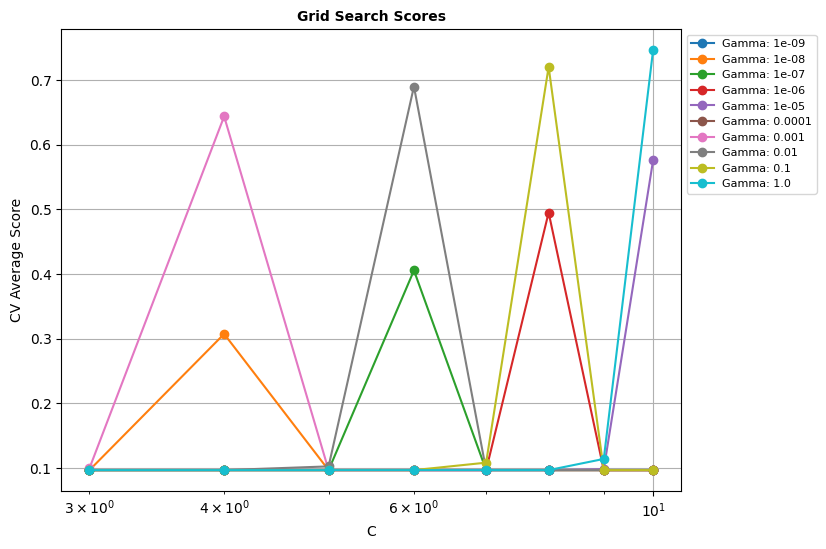

In [296]:
plot_grid_search(results_grid_svm_sigmoid, all_values_C_rbf_sigmoid, all_values_Gamma, 'C', 'Gamma')